In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import nrrd
print("------------------------------------------------------------------------------------------------")
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print("------------------------------------------------------------------------------------------------")

2024-06-09 23:54:46.367219: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 23:54:47.358976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


------------------------------------------------------------------------------------------------
2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
------------------------------------------------------------------------------------------------


In [2]:

def encoder_block(inputs, output_channels, lastlayer=False):
    """
    Two 3x3x3 convolutions with batch normalization and ReLU activation
    2x2x2 max pool
    """

    # 3x3x3 convolutions with ReLU activation
    x = tf.keras.layers.Conv3D(int(output_channels/2), kernel_size=3, strides=1, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv3D(output_channels, kernel_size=3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # 2x2x2 max pool

    if not lastlayer:
        x_maxPool = tf.keras.layers.MaxPool3D(pool_size=2, strides=2, padding = 'same')(x)
    else:
        x_maxPool = x

    return x, x_maxPool

def decoder_block(inputs, skip_features, output_channels):

    # Upsampling with 2x2x2 filter
    x = tf.keras.layers.Conv3DTranspose(output_channels*2, kernel_size=2, strides=2, padding = 'same')(inputs)

# Concatenate the skip features
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # 2 convolutions with 3x3 filter, batch normalization, ReLU activation
    x = tf.keras.layers.Conv3D(output_channels, kernel_size=3, strides=1, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv3D(output_channels, kernel_size=3, strides=1, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    return x

def unet_3D():
    inputs = tf.keras.Input(shape=(64, 64, 64, 1,))

    e1_skip, e1_maxpool = encoder_block(inputs, 64)
    e2_skip, e2_maxpool = encoder_block(e1_maxpool, 128)
    e3_skip, e3_maxpool = encoder_block(e2_maxpool, 256)
    _, e4 = encoder_block(e3_maxpool, 512, True)

    decoder1 = decoder_block(e4, e3_skip, 256)
    decoder2 = decoder_block(decoder1, e2_skip, 128)
    decoder3 = decoder_block(decoder2, e1_skip, 64)

    outputs = tf.keras.layers.Conv3D(1, 1, strides = 1)(decoder3)
    outputs = tf.keras.layers.Activation('sigmoid')(outputs)

    model = tf.keras.models.Model(inputs = inputs,  outputs = outputs,  name = 'Unet3D')

    return model
    

In [3]:
def iou(y_true, y_pred, smooth=1):
    yt = K.argmax(y_true, axis=2)
    yp = K.argmax(y_pred, axis=2)

    intersection = K.sum(yt * yp, axis=1)
    union = K.sum(yt, axis=1) + K.sum(yp, axis=1)
    return (intersection + smooth) / (union-intersection+smooth)

In [4]:
model = unet_3D()
# model.summary()

print("compiling model")
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='dice')#, metrics=[iou])

2024-06-09 23:54:50.204972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9705 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:65:00.0, compute capability: 8.9


compiling model


In [5]:
import ast
my_file = open("trainlist.txt", "r")
trainlist = my_file.read()
trainlist = ast.literal_eval(trainlist)

print("loading inputs")

number_inputs = len(trainlist)

X, _ =  nrrd.read("inputs/" + trainlist[0])
X = np.array([X]).astype(np.float32)
X = np.expand_dims(X, -1)
for i in range(1, number_inputs):

    try:
        volume, _ =  nrrd.read("inputs/" + trainlist[i])
        volume = np.array([volume])
        volume = np.expand_dims(volume, -1)
        X = np.concatenate((X, volume), axis=0)
    except:
        print("skipping " + trainlist[i])

print("loading ground truths")

valid_samples = [trainlist[0]]

y, _ =  nrrd.read("gt/" + trainlist[0])
y = np.array([y])
y = np.expand_dims(y, axis=-1)

for i in range(1, number_inputs):
    try:
        volume, _ =  nrrd.read("gt/" + trainlist[i])
        volume = np.array([volume])
        volume = np.expand_dims(volume, axis=-1)
        y = np.concatenate((y, volume), axis=0)
        valid_samples.append(trainlist[i])
    except:
        print("skipping " + trainlist[i])



loading inputs
skipping 31_volume_10.nrrd
skipping 63_volume_8.nrrd
skipping 84_volume_7.nrrd
skipping 91_volume_10.nrrd
skipping 91_volume_9.nrrd
loading ground truths
skipping 31_volume_10.nrrd
skipping 63_volume_8.nrrd
skipping 84_volume_7.nrrd
skipping 91_volume_10.nrrd
skipping 91_volume_9.nrrd


In [6]:
# Checkpoint Saving
checkpoint_path = "./checkpoints/cp-{epoch:04d}.weights.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1,
                                                 save_weights_only=True, save_freq='epoch') #save_freq=1850)


print("---------------- fitting model ---------------------")
model.fit(x=X, y=y, batch_size=2, epochs=200, callbacks = [cp_callback])

---------------- fitting model ---------------------
Epoch 1/200


I0000 00:00:1717917667.885948  785331 service.cc:145] XLA service 0x7fecec002ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717917667.886028  785331 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-06-09 03:21:08.071937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-09 03:21:08.732756: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


  1/185 ━━━━━━━━━━━━━━━━━━━━ 1:17:12 25s/step - loss: 1.0000

I0000 00:00:1717917687.033722  785331 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.9956
Epoch 1: saving model to ./checkpoints/cp-0001.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 53s 151ms/step - loss: 0.9956
Epoch 2/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.9875
Epoch 2: saving model to ./checkpoints/cp-0002.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - loss: 0.9875
Epoch 3/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.9596
Epoch 3: saving model to ./checkpoints/cp-0003.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - loss: 0.9595
Epoch 4/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 1.0000
Epoch 4: saving model to ./checkpoints/cp-0004.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - loss: 1.0000
Epoch 5/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 1.0000
Epoch 5: saving model to ./checkpoints/cp-0005.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - loss: 1.0000
Epoch 6/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 1.0000
Epoch 6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[[[8.6459795e-07]
   [1.0981151e-06]
   [1.1590114e-06]
   ...
   [1.4504379e-06]
   [1.2521996e-06]
   [9.4349360e-07]]

  [[1.1304173e-06]
   [1.8038630e-06]
   [2.2775005e-06]
   ...
   [3.4063730e-06]
   [2.1515882e-06]
   [1.2205182e-06]]

  [[1.2039828e-06]
   [2.2860022e-06]
   [3.6862907e-06]
   ...
   [6.9722432e-06]
   [2.9450632e-06]
   [1.3227653e-06]]

  ...

  [[1.2692458e-06]
   [2.3622185e-06]
   [3.3048593e-06]
   ...
   [4.8163183e-06]
   [2.6357120e-06]
   [1.3154062e-06]]

  [[1.1349584e-06]
   [1.7539218e-06]
   [2.0156231e-06]
   ...
   [2.5918273e-06]
   [2.0033888e-06]
   [1.2422961e-06]]

  [[8.7786322e-07]
   [1.1065980e-06]
   [1.1294744e-06]
   ...
   [1.3235061e-06]
   [1.2742269e-06]
   [9.8464272e-07]]]


 [[[1.1396440e-06]
   [1.7832060e-06]
   [2.1645749e-06]
   ...
   [3.3226922e-06]
   [2.2010597e-06]
   [1.2602395e-06]]

  [[1.9085485e-06]
   [4.7757121e-06]
   [8.4683470e-06]
   ...
   [1.7586448e-05]
   [6.282

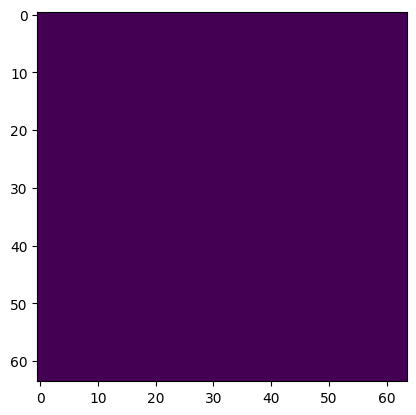

(<matplotlib.image.AxesImage at 0x7cdcfc5c38c0>, None)

In [8]:
import os
import matplotlib.pyplot as plt

#X, _ = nrrd.read("./test_volumes/11_volume_11.full.nrrd")
X, _ = nrrd.read("./inputs/2_volume_5.nrrd")
X = np.array([X]).astype(np.float32)
X = np.expand_dims(X, -1)

y = model.predict(X)
y = y[0]
print(y)
#print(y[0])
# y = np.argmax(y, axis=1)
y[y>=0.5]=1
y[y<0.5]=0

print(y.shape)
print(np.unique(y))
plt.imshow(y[:,:,23]), plt.show()

# output = np.reshape(y, (64, 64, 64)).astype(np.uint8)
# print(output.shape)
# print(type(output[0,0,0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
cp-0177.weights.h5


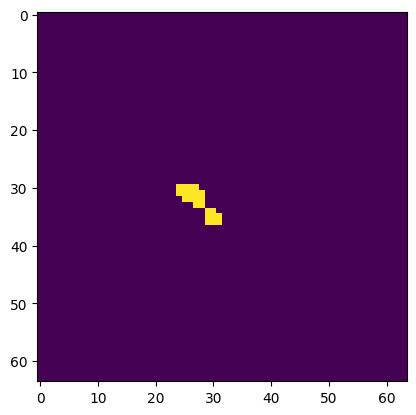

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0091.weights.h5


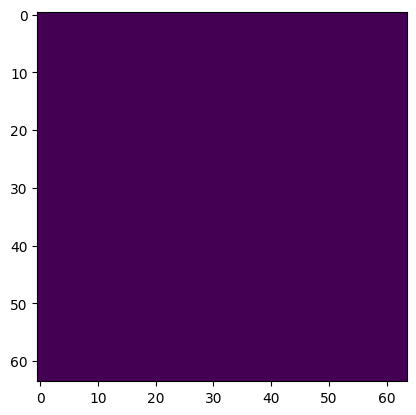

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0107.weights.h5


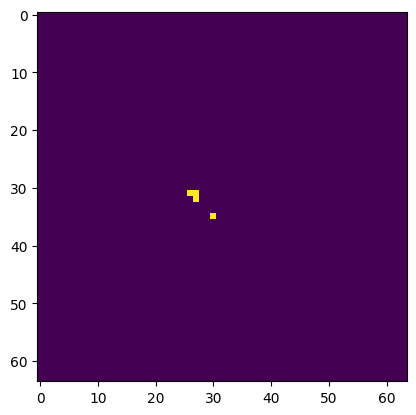

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0029.weights.h5


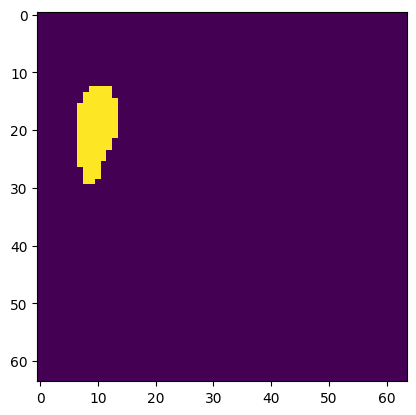

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0111.weights.h5


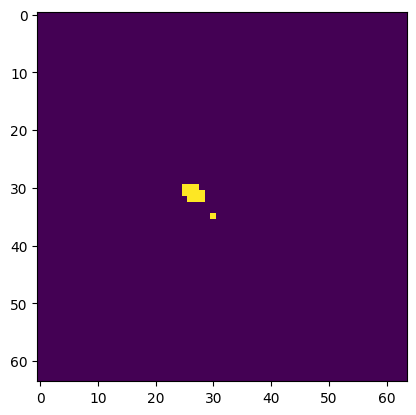

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0164.weights.h5


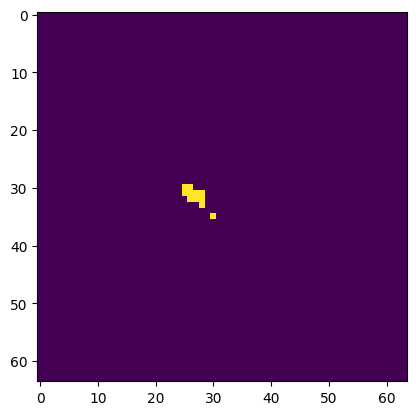

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0136.weights.h5


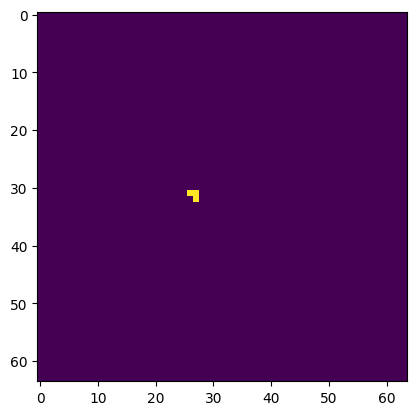

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0192.weights.h5


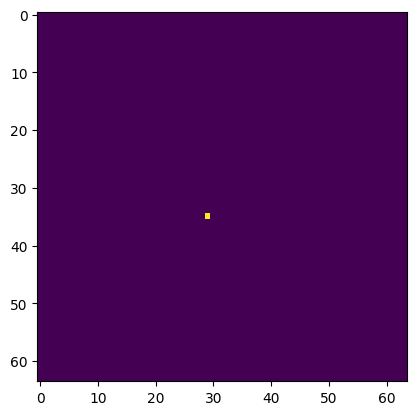

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0123.weights.h5


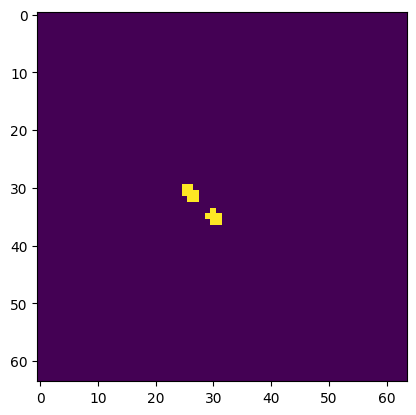

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0070.weights.h5


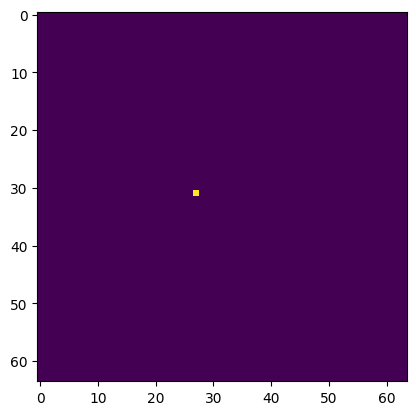

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0026.weights.h5


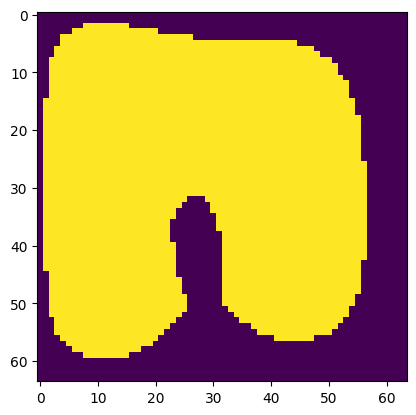

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0140.weights.h5


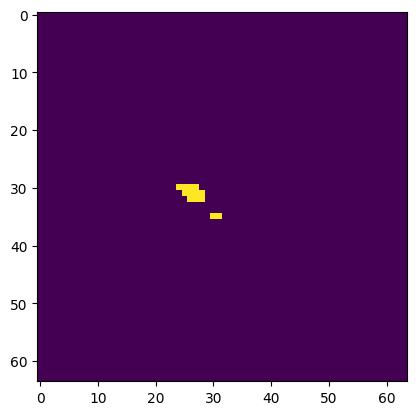

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0077.weights.h5


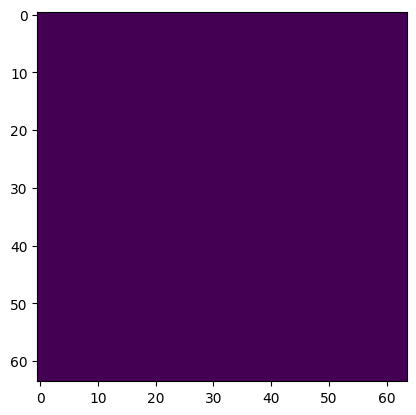

error with: cp-0360.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
error with: cp-0260.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0160.weights.h5


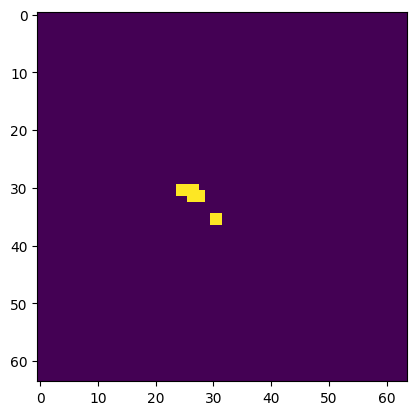

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0108.weights.h5


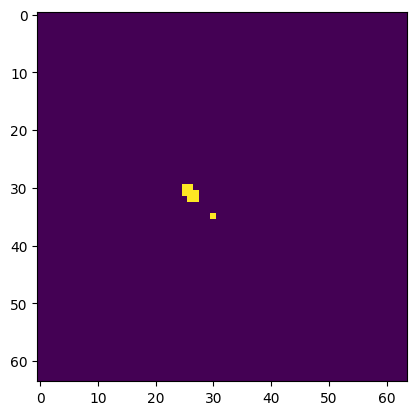

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
cp-0150.weights.h5


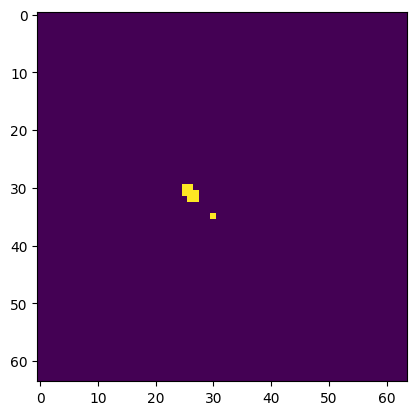

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0074.weights.h5


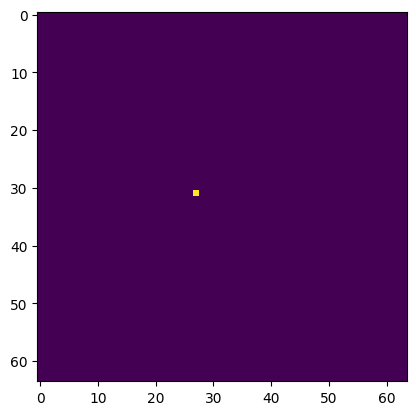

error with: cp-0230.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0090.weights.h5


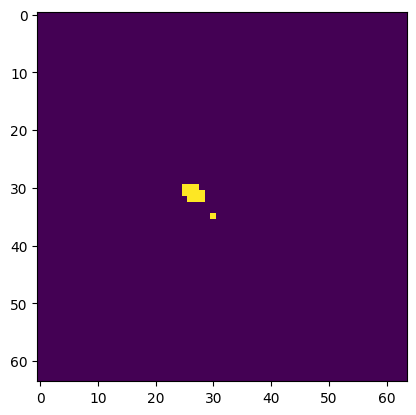

error with: cp-0300.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0185.weights.h5


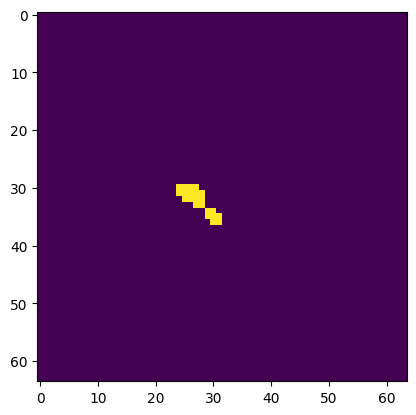

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
cp-0121.weights.h5


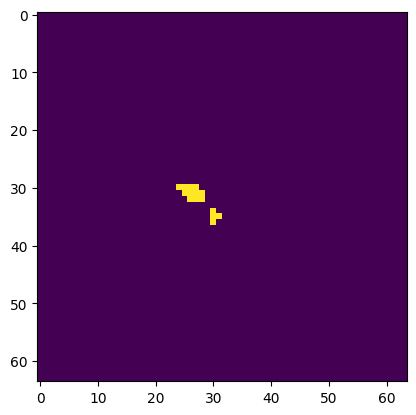

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0103.weights.h5


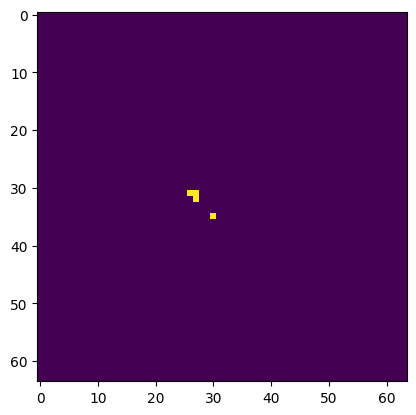

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0133.weights.h5


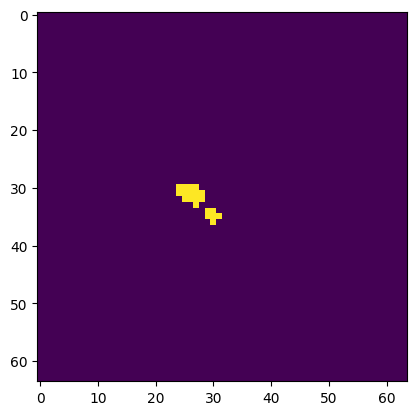

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
cp-0071.weights.h5


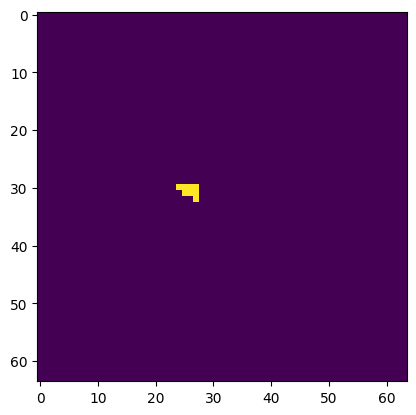

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0110.weights.h5


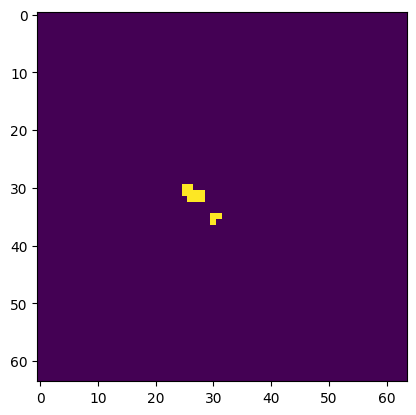

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0198.weights.h5


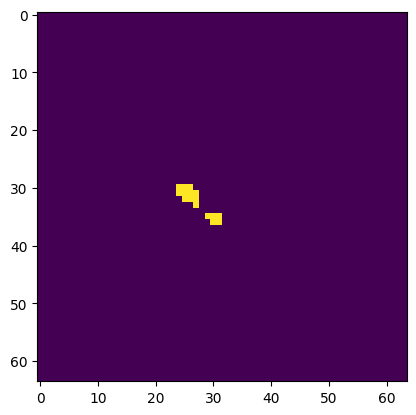

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0132.weights.h5


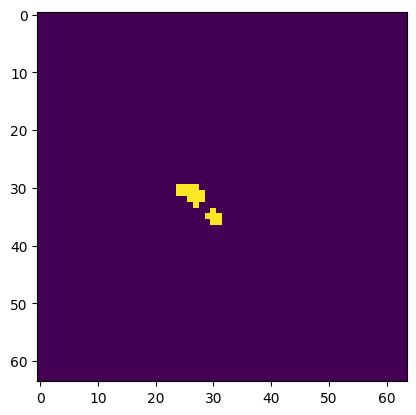

error with: cp-0330.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
cp-0149.weights.h5


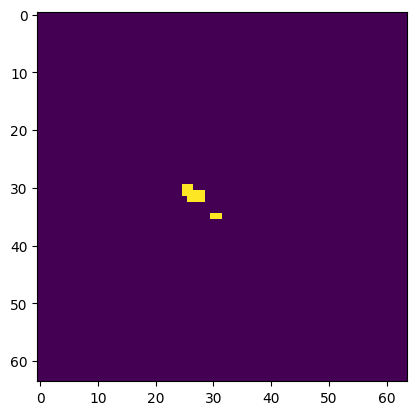

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0183.weights.h5


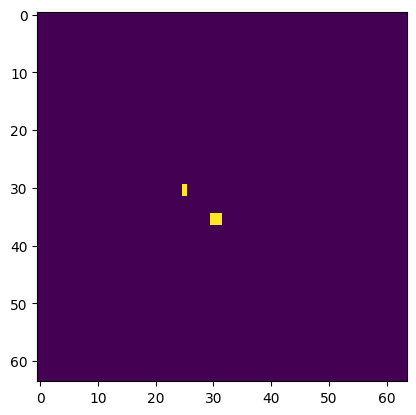

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0147.weights.h5


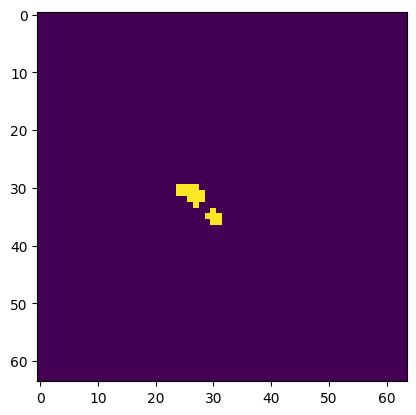

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0181.weights.h5


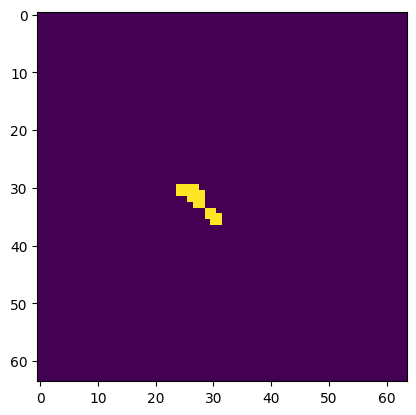

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0125.weights.h5


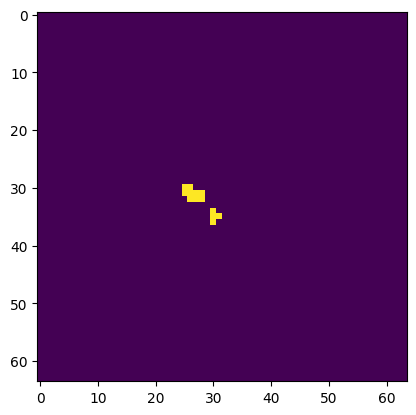

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0102.weights.h5


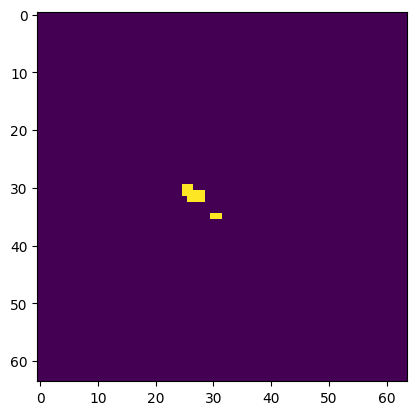

error with: cp-0220.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0130.weights.h5


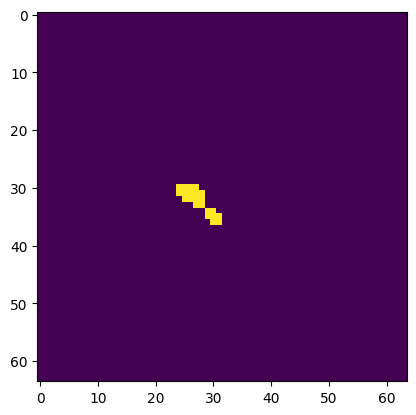

error with: cp-0380.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0031.weights.h5


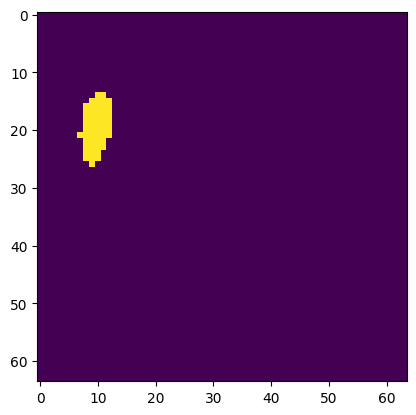

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0158.weights.h5


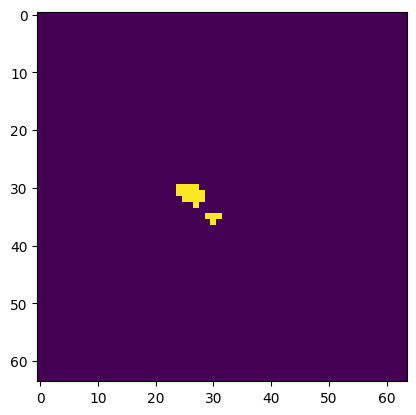

error with: cp-0280.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0169.weights.h5


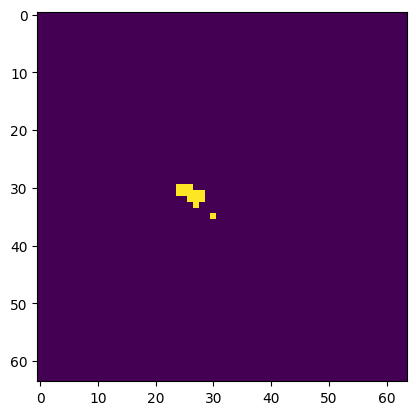

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0120.weights.h5


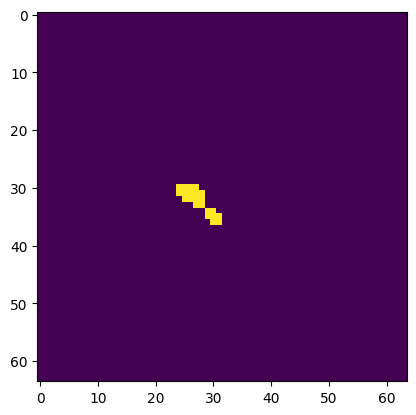

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0167.weights.h5


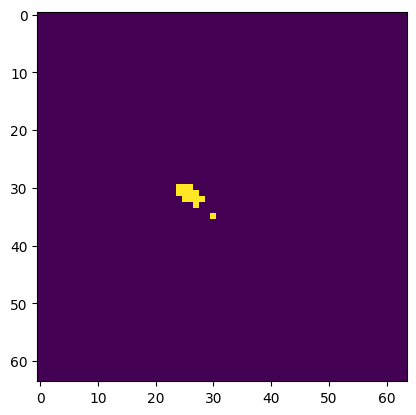

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0135.weights.h5


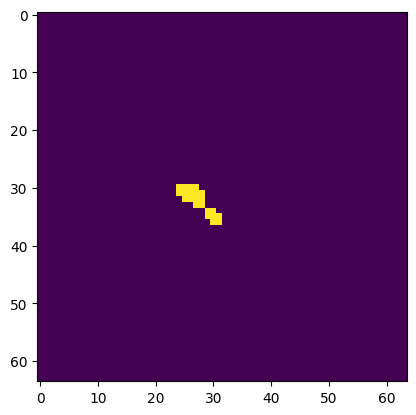

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
cp-0126.weights.h5


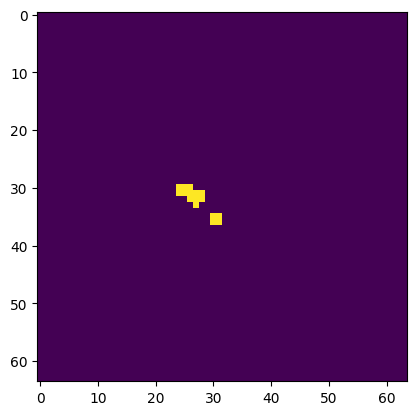

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0152.weights.h5


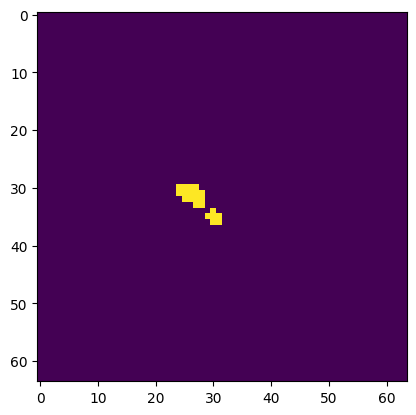

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0128.weights.h5


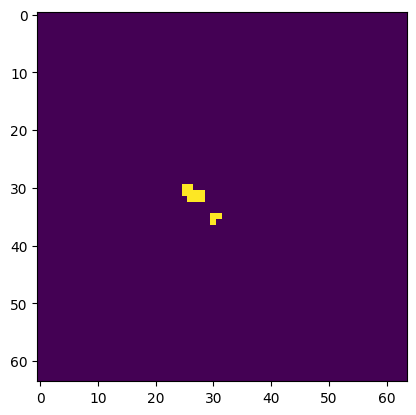

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0106.weights.h5


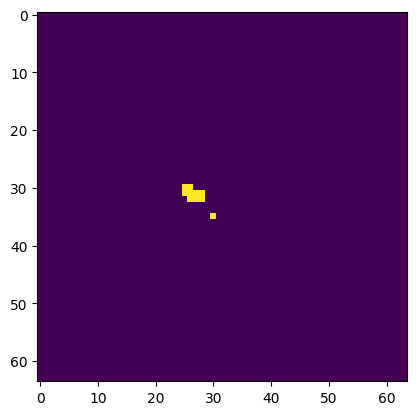

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0088.weights.h5


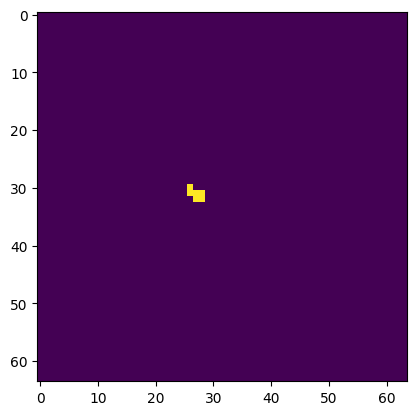

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0190.weights.h5


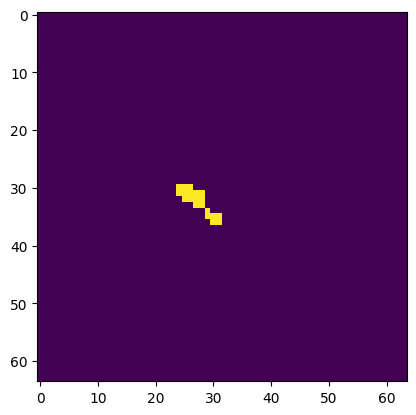

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
error with: cp-0250.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0118.weights.h5


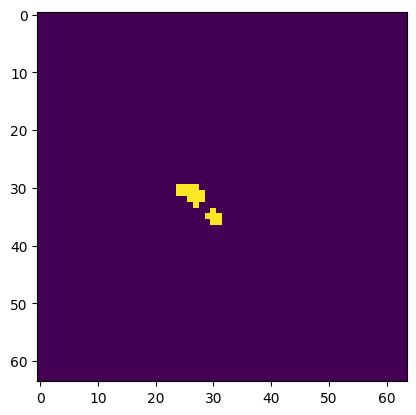

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0069.weights.h5


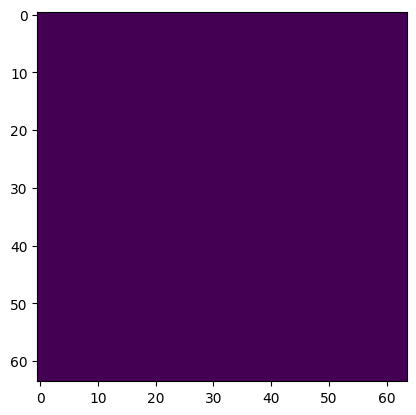

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0163.weights.h5


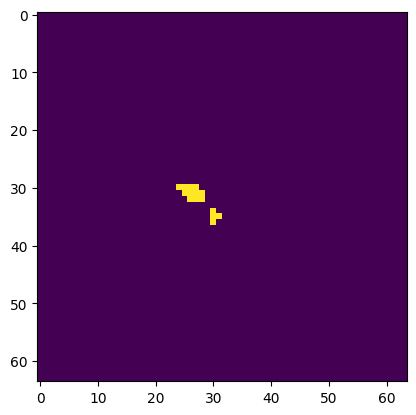

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0141.weights.h5


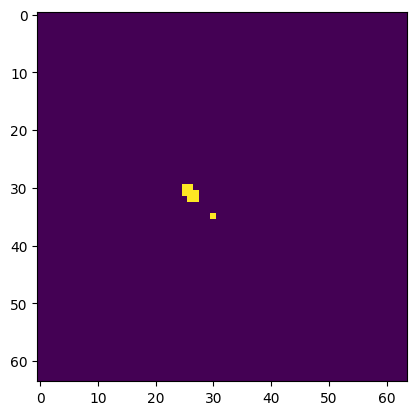

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0086.weights.h5


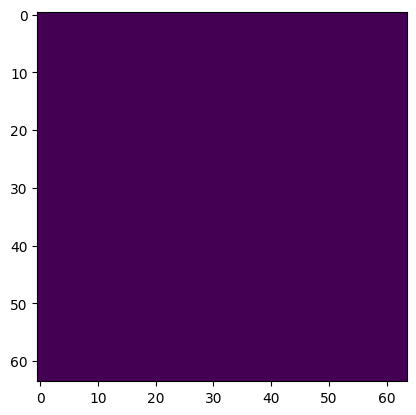

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0180.weights.h5


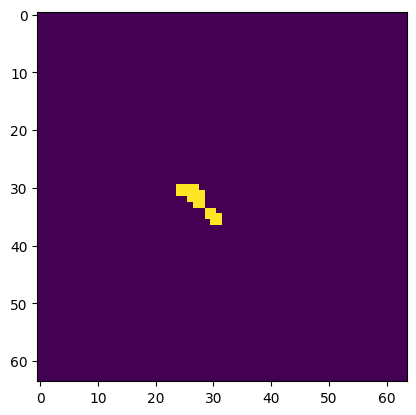

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
error with: cp-0370.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0119.weights.h5


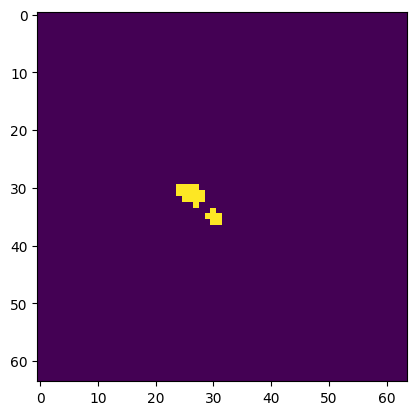

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
cp-0109.weights.h5


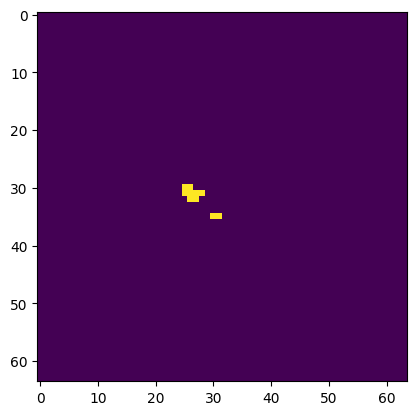

error with: cp-0400.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0171.weights.h5


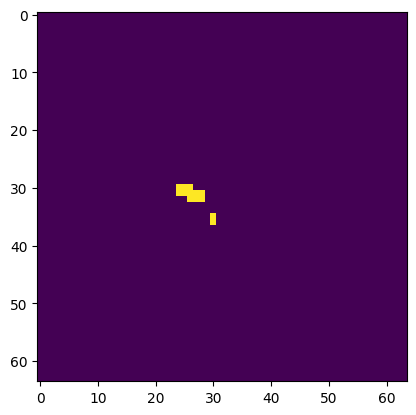

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0196.weights.h5


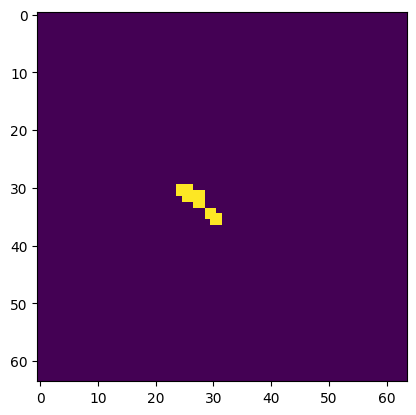

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0182.weights.h5


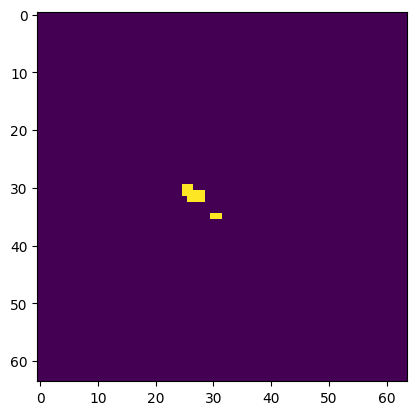

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0175.weights.h5


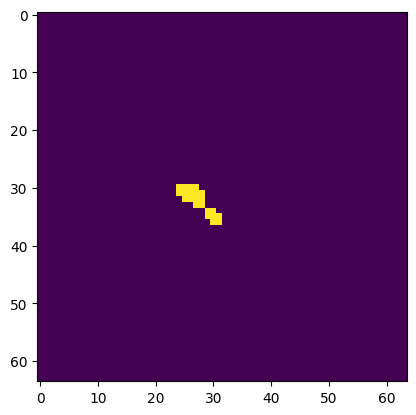

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0105.weights.h5


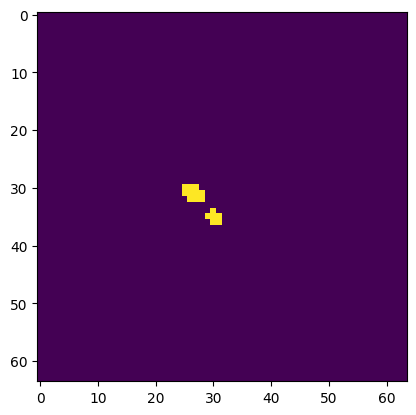

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0129.weights.h5


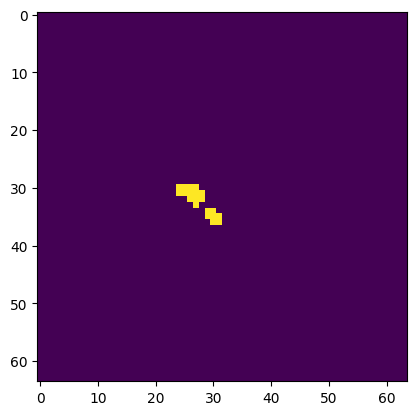

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0131.weights.h5


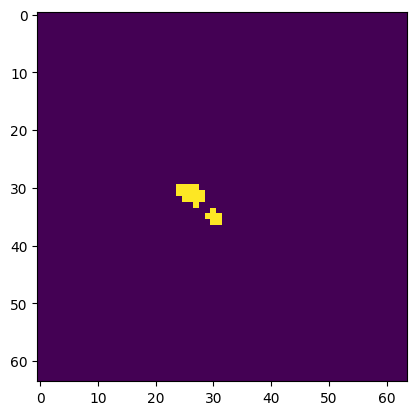

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0138.weights.h5


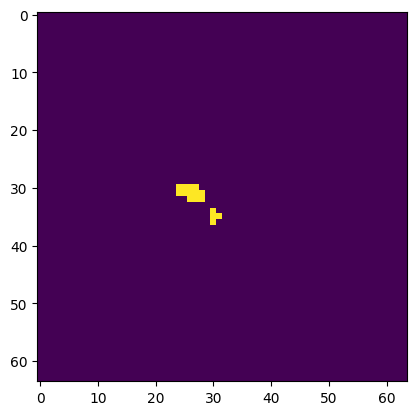

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0146.weights.h5


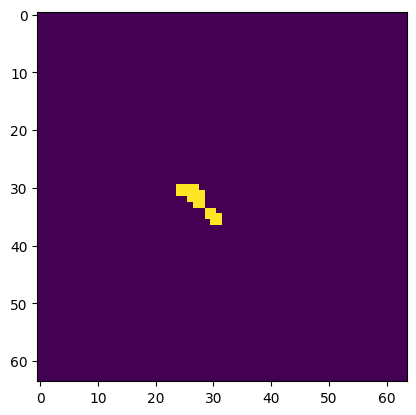

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0145.weights.h5


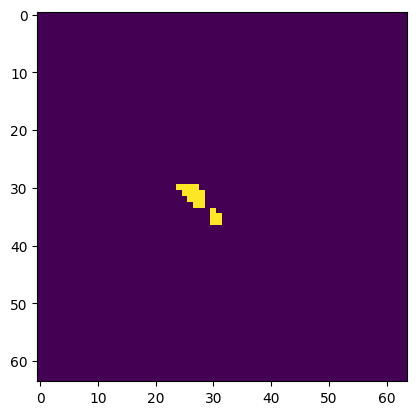

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0127.weights.h5


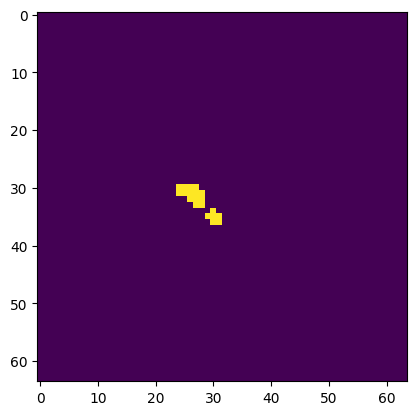

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0113.weights.h5


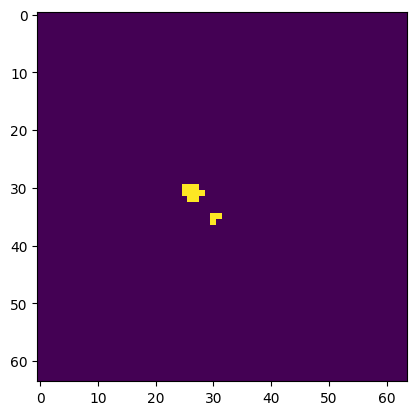

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0096.weights.h5


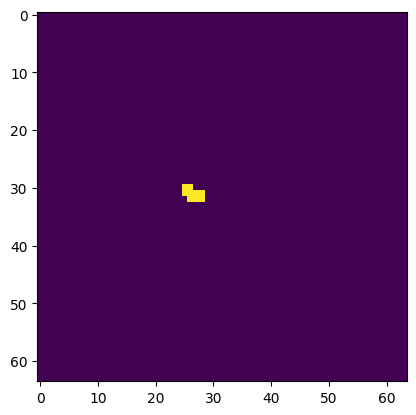

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0139.weights.h5


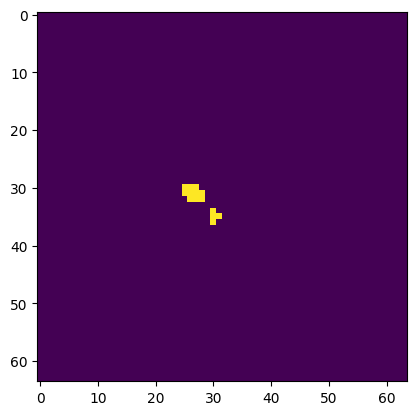

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0089.weights.h5


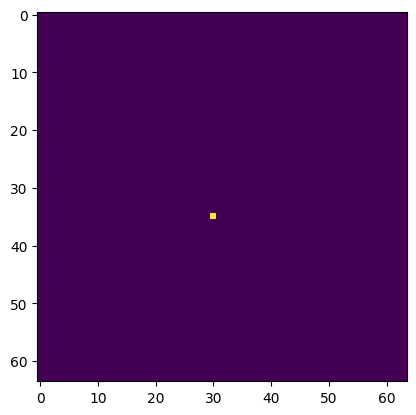

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0082.weights.h5


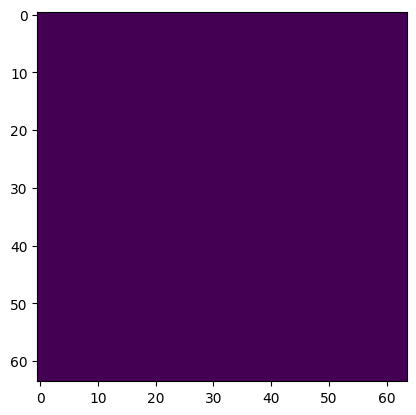

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0174.weights.h5


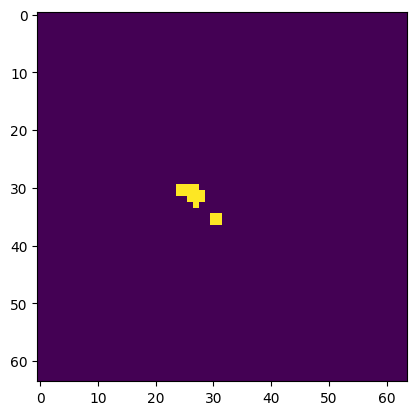

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
cp-0191.weights.h5


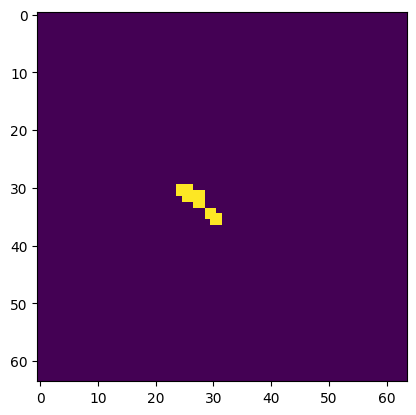

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0092.weights.h5


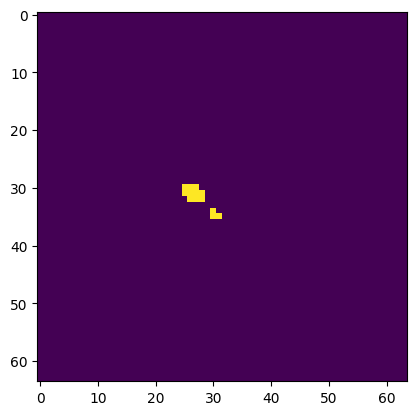

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0112.weights.h5


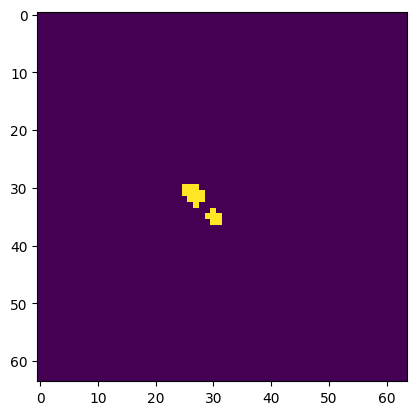

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0187.weights.h5


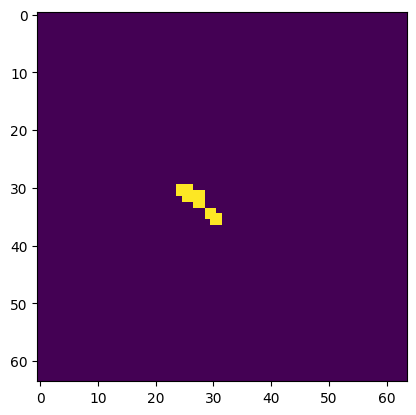

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0155.weights.h5


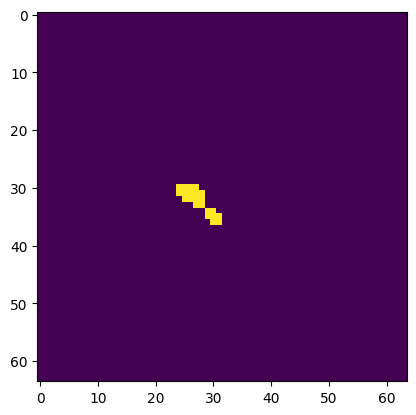

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
cp-0072.weights.h5


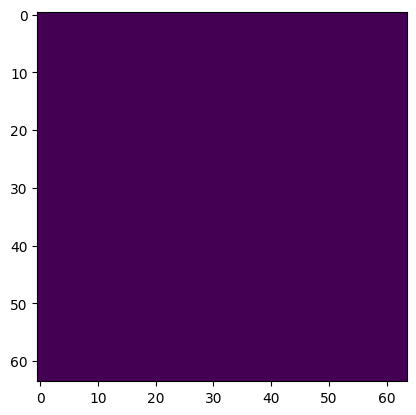

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0194.weights.h5


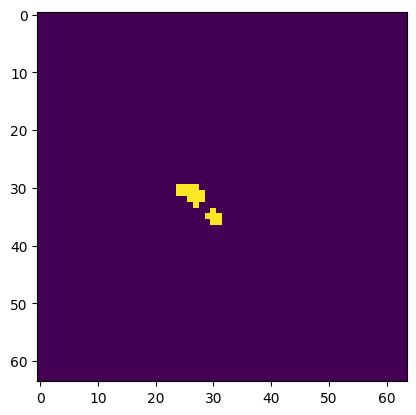

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0166.weights.h5


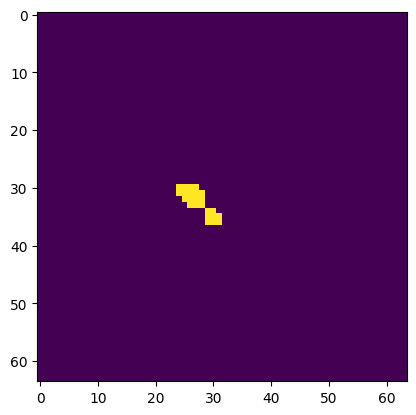

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
cp-0009.weights.h5


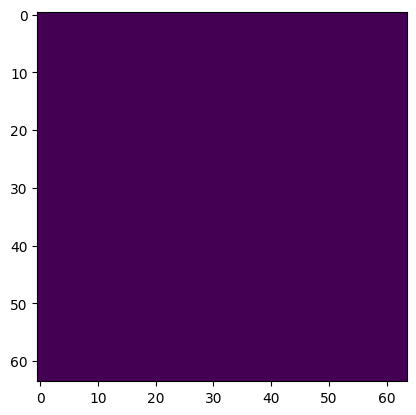

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
cp-0162.weights.h5


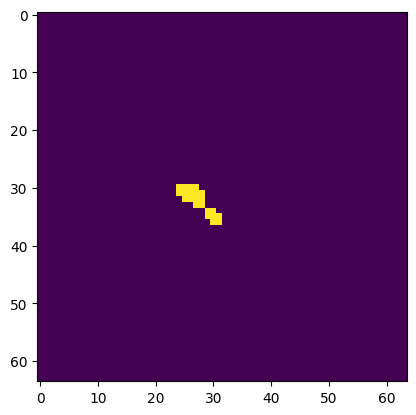

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0157.weights.h5


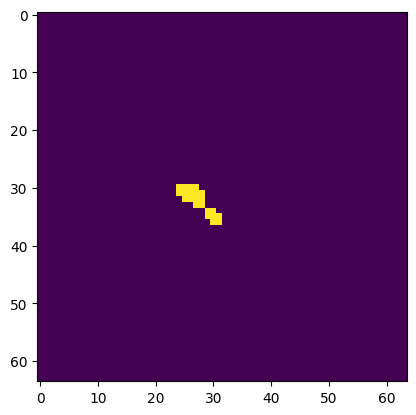

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0154.weights.h5


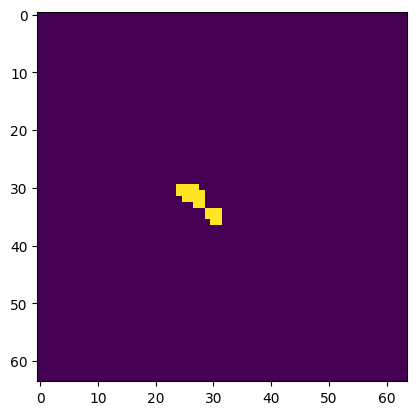

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0134.weights.h5


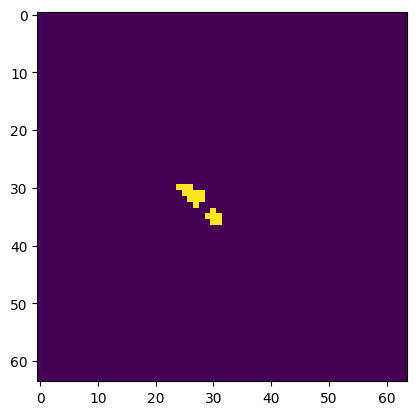

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0178.weights.h5


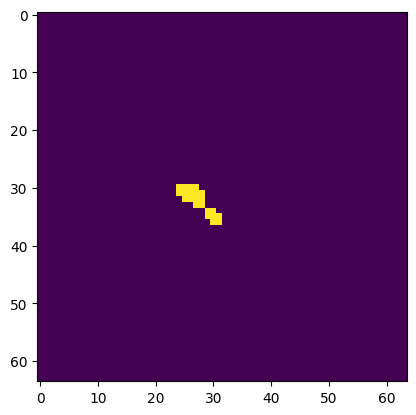

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0062.weights.h5


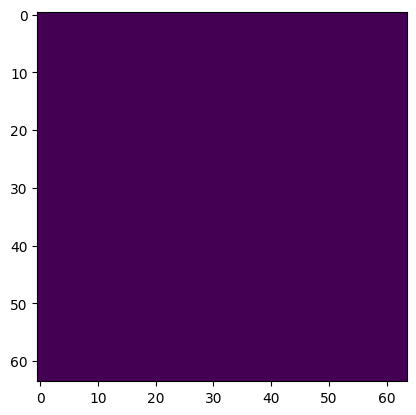

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
error with: cp-0350.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0184.weights.h5


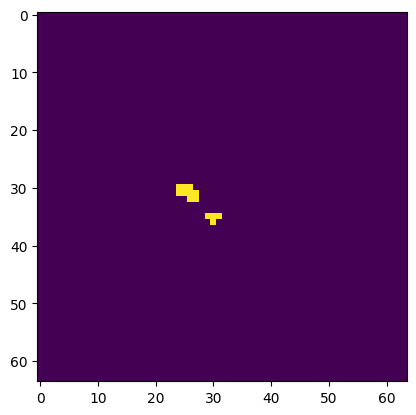

error with: cp-0310.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0189.weights.h5


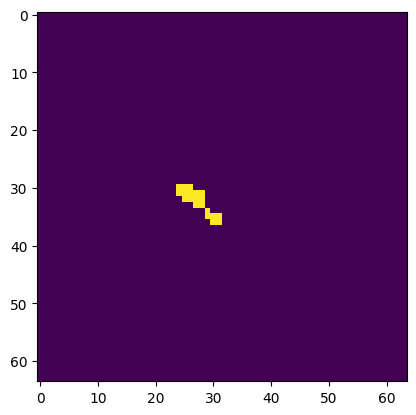

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0193.weights.h5


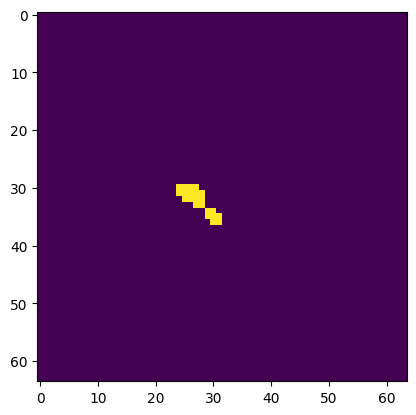

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0116.weights.h5


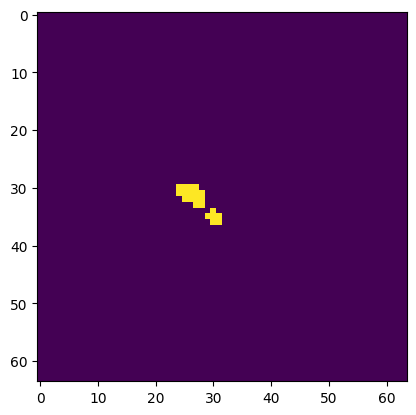

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0137.weights.h5


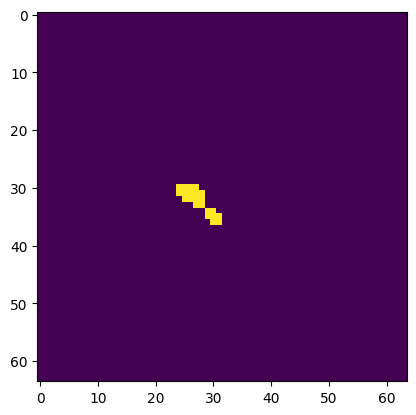

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0030.weights.h5


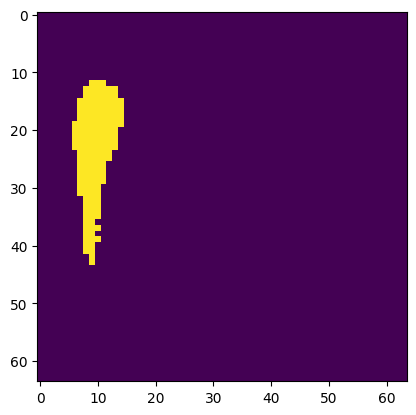

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
cp-0188.weights.h5


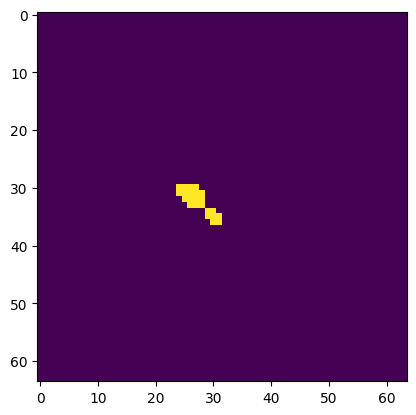

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0165.weights.h5


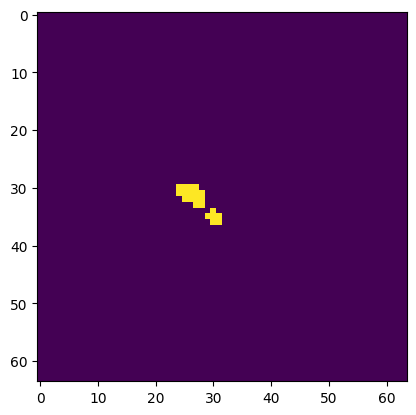

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0161.weights.h5


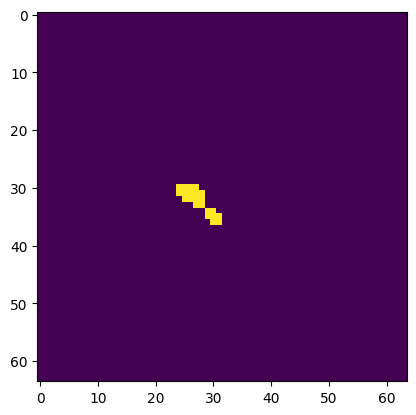

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
error with: cp-0210.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0035.weights.h5


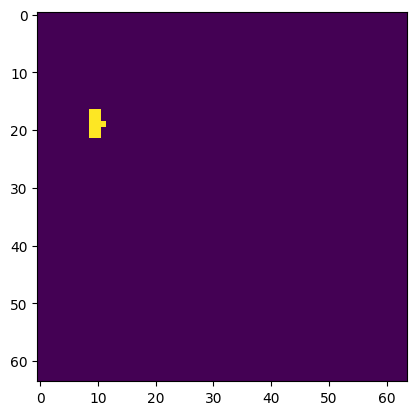

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0094.weights.h5


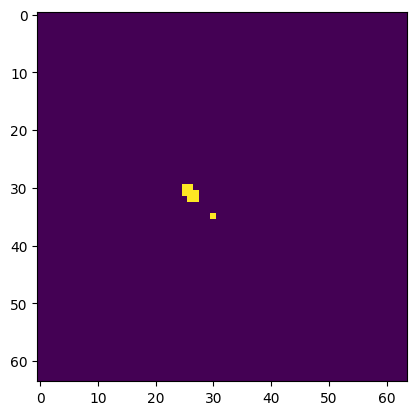

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0168.weights.h5


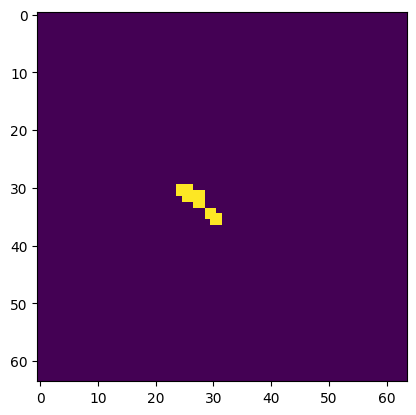

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0099.weights.h5


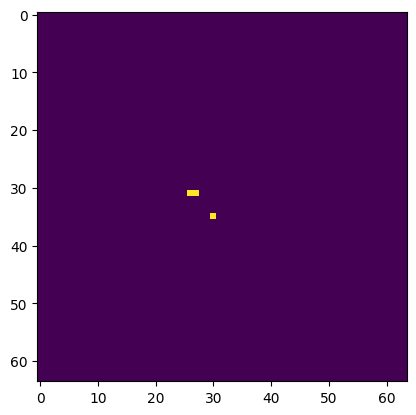

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0114.weights.h5


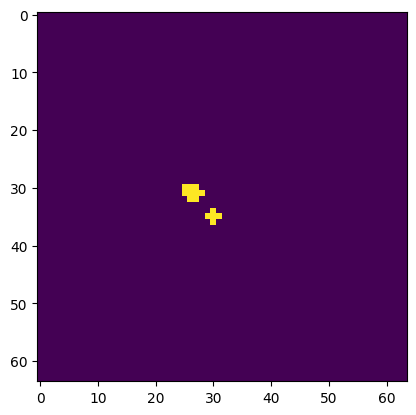

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0115.weights.h5


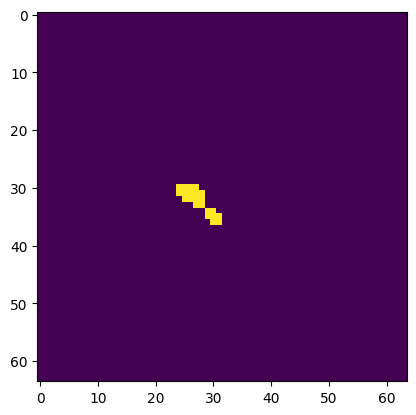

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0084.weights.h5


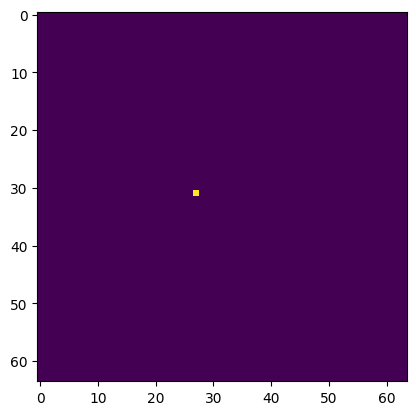

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
cp-0156.weights.h5


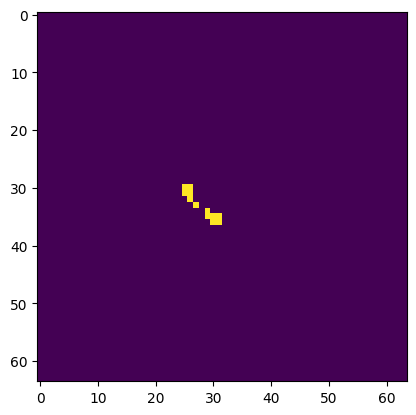

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0028.weights.h5


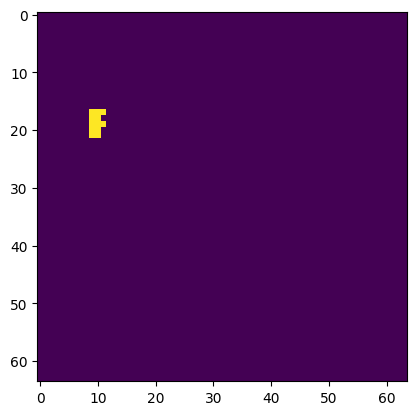

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0143.weights.h5


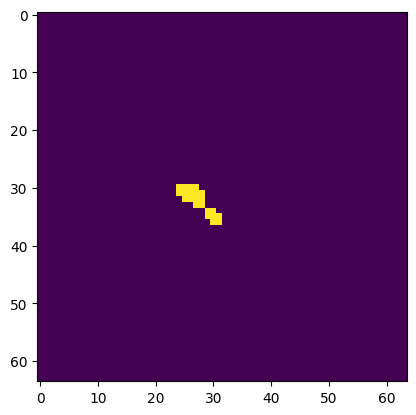

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0195.weights.h5


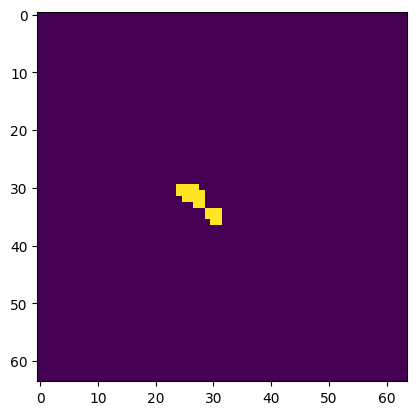

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0124.weights.h5


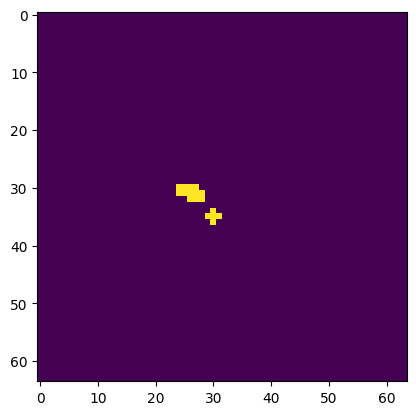

error with: cp-0240.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0117.weights.h5


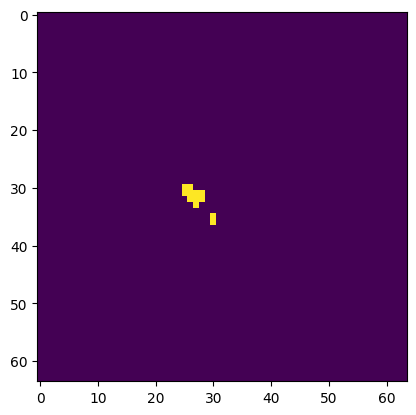

error with: cp-0390.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0172.weights.h5


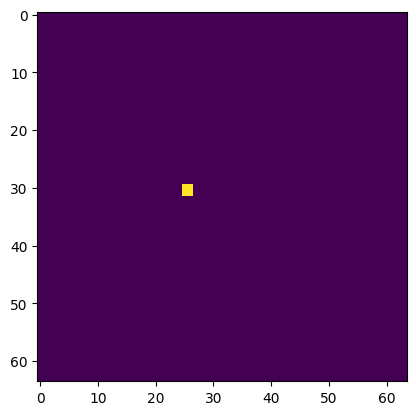

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
error with: cp-0270.weights.h5
error with: cp-0320.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0039.weights.h5


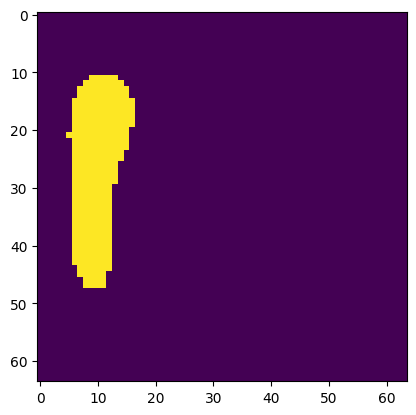

error with: cp-0290.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0153.weights.h5


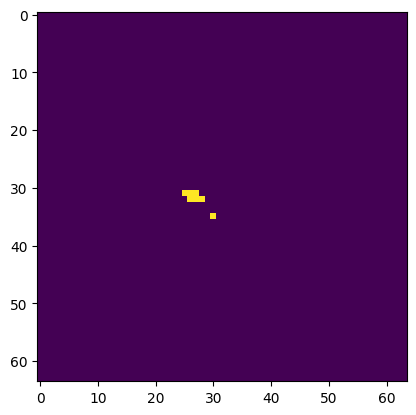

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0176.weights.h5


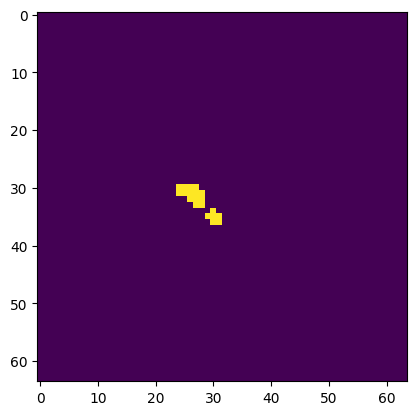

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
cp-0197.weights.h5


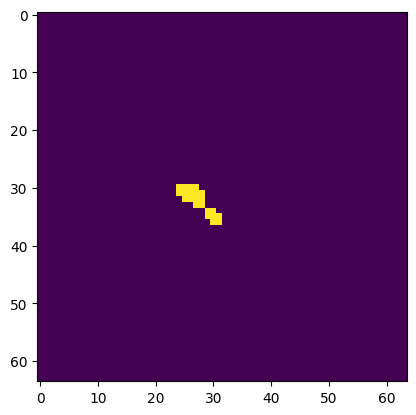

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0170.weights.h5


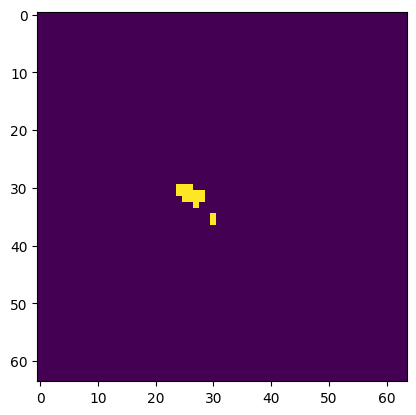

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0100.weights.h5


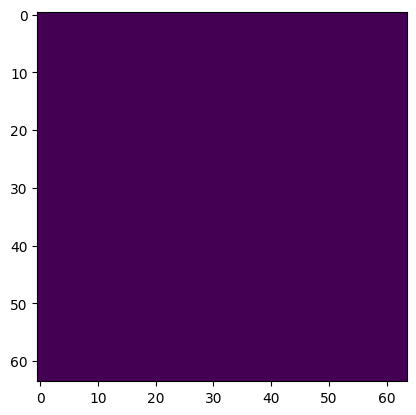

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0200.weights.h5


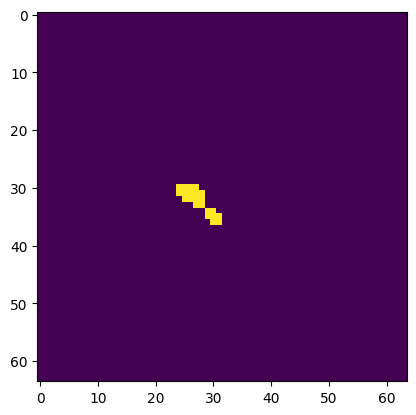

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
error with: cp-0340.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0073.weights.h5


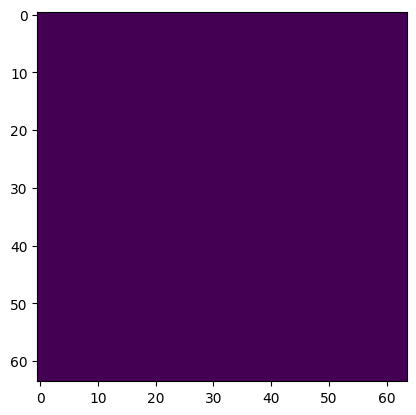

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
cp-0148.weights.h5


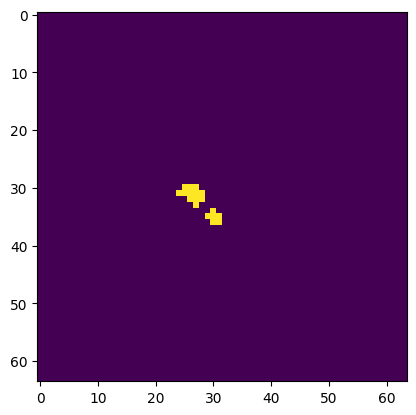

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0159.weights.h5


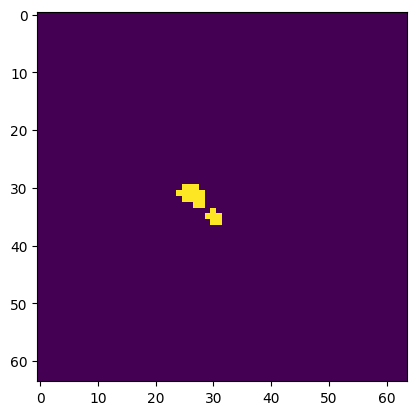

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0186.weights.h5


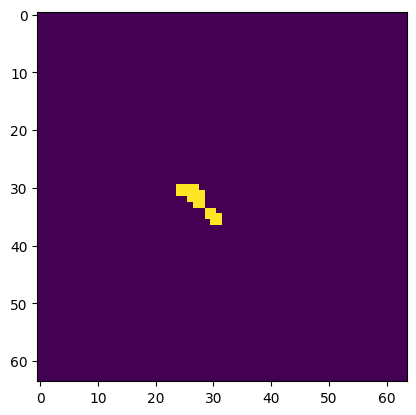

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0179.weights.h5


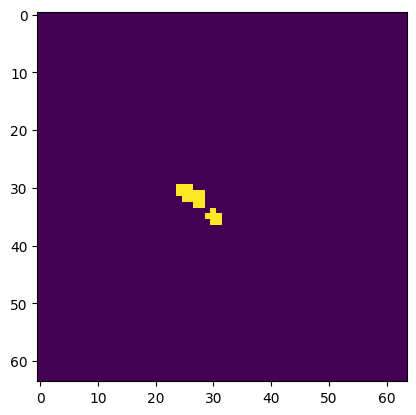

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0104.weights.h5


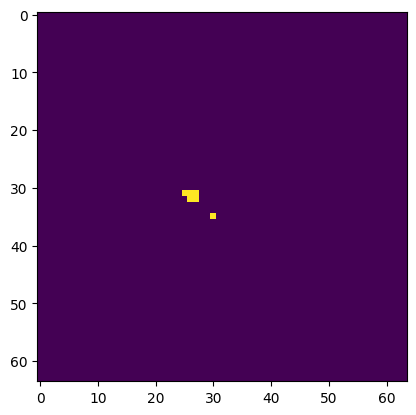

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
cp-0027.weights.h5


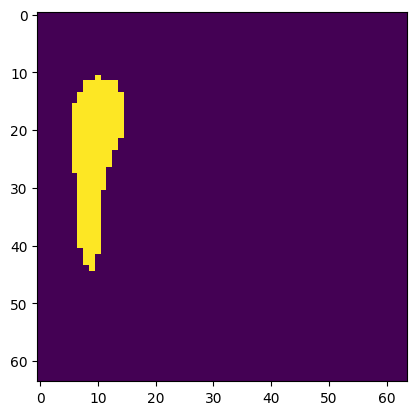

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cp-0122.weights.h5


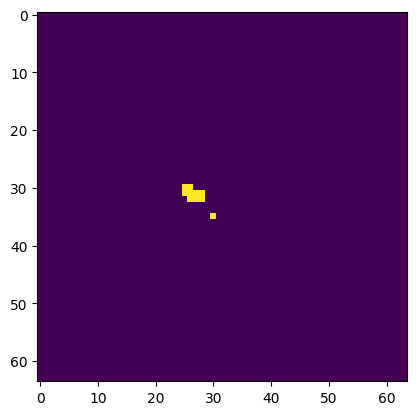

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [6]:
import os
import matplotlib.pyplot as plt

X, _ = nrrd.read("./inputs/2_volume_5.nrrd")
X = np.array([X]).astype(np.float32)
X = np.expand_dims(X, -1)

for checkpoint in os.listdir("./checkpoints"):
    try:
        model.load_weights("./checkpoints/"+checkpoint)
    
        
        y = model.predict(X)
        y = y[0]
        # y = np.argmax(y, axis=1)
        y[y>=0.5]=1
        y[y<0.5]=0
        if len(np.unique(y)) > 1:
            # output = np.reshape(y, (64, 64, 64)).astype(np.uint8)
            print(checkpoint)
            plt.imshow(y[:,:,23]), plt.show()
    except:
        print("error with: " + checkpoint)

1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


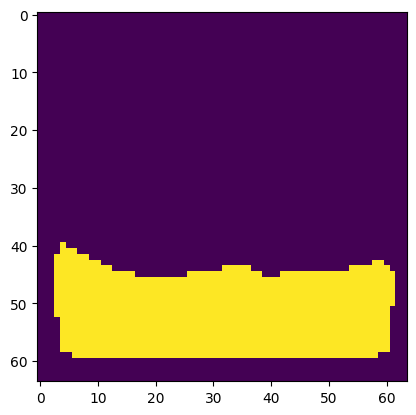

4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [11]:
import os
import matplotlib.pyplot as plt

X, _ = nrrd.read("./inputs/2_volume_5.nrrd")
X = np.array([X]).astype(np.float32)
X = np.expand_dims(X, -1)

for i in range(1, 5):
    print(i)
    model.load_weights("./checkpoints/cp-000"+str(i)+".weights.h5")

    
    y = model.predict(X)
    y = y[0]
    # y = np.argmax(y, axis=1)
    y[y>=0.5]=1
    y[y<0.5]=0
    if len(np.unique(y)) > 1:
        #output = np.reshape(y, (64, 64, 64)).astype(np.uint8)
        plt.imshow(y[:,:,23]), plt.show()

In [25]:
y, _ =  nrrd.read("gt/" + trainlist[0])
# y = np.reshape(y, (64*64*64))
y = np.array([y])
y = np.expand_dims(y, axis=-1)
y.shape

(1, 64, 64, 64, 1)